# Lockstep, the full recipe, Part 2: Training

By the time you're here you should have everything you need to feed into the random forest model that is Lockstep's top layer. 

That means:
* Compiled User Details, with sample selection index numbers saved in assembled_user_details.parquet* ,and selected.csv* - respectively.
* URL Confidence Scores in url_predict.csv*
* Graph Model Predictions in gs_predict.csv


`* unless this has been changed in the script

In [1]:
import pandas as pd
import gc
from pathlib import Path
import os
from collections import defaultdict
from fastparquet import ParquetFile

verbosity = 5

twibot_path = r"/dataset/twibot22"
twibot_user = r"/dataset/twibot22/user.json"
twibot_label = r"/dataset/twibot22/label.csv"
twibot_graph_file = f"{twibot_path}/edge.csv"

generated_data_output = r"/dataset/twibot22/generated_data" # output is saved in this directory
ls_selected_indices_output = os.path.join(generated_data_output, "selected.csv")
ls_userdata_output_parquet = "assembled_user_details.parquet"
url_model_output = os.path.join(generated_data_output,"url_model.pkl")
url_model_prediction_output = os.path.join(generated_data_output,"url_predict.csv")


gnn_output_folder = os.path.join(generated_data_output,"gs_output")
gnn_output_dataset_name = os.path.join(gnn_output_folder,"gnn_graph_data.pt")
gnn_output_checkpoint_name = os.path.join(gnn_output_folder,"graphsage_model.ckpt")
gnn_output_relmap_name = os.path.join(gnn_output_folder,"relationship_map.pkl")
gnn_output_map_name = os.path.join(gnn_output_folder,"index_map.json")
gnn_output_predictions_name =  os.path.join(gnn_output_folder,"gs_predictions.csv")
gnn_output_model_path = os.path.join(gnn_output_folder,"graphsage_final.pt")

# Files in the path specified by twibot_path, that begin with %twibot_node_identifier_str%, will be assumed as node files and converted if needed.
twibot_node_identifier_str = "tweet_" 
NODE_FILE_LIST = list(filter(lambda fileName: twibot_node_identifier_str in fileName, 
                                        [child.name for child in Path(generated_data_output).iterdir()]))

scores = {}

top_do_normalize = True 

top_level_rf_best_params_50k =  {'n_estimators': 600,
                'min_samples_split': 10,
                'min_samples_leaf': 2,
                'min_impurity_decrease': 0.0, 
                'max_leaf_nodes': None,
                'max_features': None,
                'max_depth': 40,
                'criterion': 'entropy',
                'class_weight': 'balanced'
               }

best_params_10k = {'n_estimators': 600,
                   'min_samples_split': 15,
                   'min_samples_leaf': 3,
                   'min_impurity_decrease': 0.0,
                   'max_leaf_nodes': None,
                   'max_features': None,
                   'max_depth': 40,
                   'criterion': 'entropy',
                   'class_weight': 'balanced'}
# {'n_estimators': 600, 'min_samples_split': 15, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 35, 'criterion': 'entropy', 'class_weight': 'balanced'}
top_level_rf_best_params  = best_params_10k

if not Path(gnn_output_folder).exists:
    os.mkdir(gnn_output_folder)
    
def debug_print(m, level=5, r=None):
    if level <= verbosity:
        print(m)
        if r:
            raise r
    
def is_data(name, _dir=generated_data_output):
    file_path = os.path.join(_dir, f"{name}.parquet")
    return os.path.exists(file_path)
    
def get_data(name, _dir=generated_data_output, pqargs={}, **kwargs):
    if is_data(name, _dir):
        file_path = os.path.join(_dir, f"{name}.parquet")
        print(f"Loading existing data from {file_path}")
        #return pd.read_parquet(file_path)
        pf = ParquetFile(file_path, **pqargs)
        return pf.to_pandas(**kwargs)
    return False
        
def save_data(name, _dir=generated_data_output, df=None, **kwargs):
    if df is None:
            raise ValueError("No dataframe provided to save.")
    file_path = os.path.join(_dir, f"{name}.parquet")
    print(f"Saving data to {file_path}")
    os.makedirs(_dir, exist_ok=True)  # Ensure the directory exists
    df.to_parquet(file_path, **kwargs)
    return df      
    
def _shuffle(df):
    return df.sample(frac = 1)
    
shuffle_method = _shuffle

# To quietly stop cell execution
class StopExecution(Exception):
    def _render_traceback_(self):
        return []


import json
def get_post_counts():
    tweetNodeFilesParquet = list(filter(lambda fileName: twibot_node_identifier_str in fileName, 
                                        [child.name for child in Path(generated_data_output).iterdir()]))
    post_count_dict = defaultdict(int)
    debug_print(f"Called: get_post_counts", 5)
    for targetFile in tweetNodeFilesParquet:
        targetInput = Path(f"{generated_data_output}/{targetFile}")
        try:
            debug_print("Looking in " + targetInput.__str__(), 5)
            pf = ParquetFile(targetInput)
            df = pf.to_pandas(columns=['author_id'])
            for uid in df['author_id']:
                post_count_dict[uid] = post_count_dict[uid] + 1
            del pf, df
            gc.collect()
        except Exception as e:
            debug_print(f"Failed to load node parquet: {e}", 5)
            raise RuntimeError("Error processing Parquet files.")
    debug_print(f"Completed: get_post_counts", 5)
    return post_count_dict
    
def get_post_chunks(cols = '*', index="author_id", pqargs={}, pdkwargs={}, margs={}):
    # Result: Dataframe, index with one or more features.
    # Index: from users
    global NODE_FILE_LIST
    result_builder = None
    for targetFile in NODE_FILE_LIST:
        targetInput = Path(f"{generated_data_output}/{targetFile}")
        debug_print(f"Extracting from {targetInput.__str__()}...", 5)
        
        if cols != '*':
            # Set the columns to pull from the parquet, either through pqargs directly or here, through cols
            pdkwargs['columns'] = cols
            
        pdkwargs['index'] = index       
        try:
            pfinput = ParquetFile(targetInput, **pqargs)    
            process_group = pfinput.to_pandas(**pdkwargs)  
            result_builder = pd.concat([result_builder, process_group])         
        except Exception as e:
            debug_print(f"Failed to load node parquet: {e}", 5)
            raise RuntimeError("Error processing Parquet files.")
    return result_builder


## Step 1. Get Resources, Combine features

In [2]:

selected_users = pd.read_csv(ls_selected_indices_output)
print(f"Loaded selected indices. {selected_users.shape}")
user_data = get_data(Path(ls_userdata_output_parquet).stem)
print(f"Loaded user data.")
display(user_data.head(1))

url_model_predictions = pd.read_csv(url_model_prediction_output, usecols=['user_id','probability_class_1'])
url_model_predictions.rename({'probability_class_1': 'url_prob_score'}, axis=1, inplace=True)
url_model_predictions.set_index('user_id', inplace=True)

graph_model_predictions = pd.read_csv(gnn_output_predictions_name, usecols=['Entity ID','Probability Class 1'])
graph_model_predictions['Entity ID'] = graph_model_predictions['Entity ID'].apply(lambda v: v.strip('utl')).astype('uint64')
graph_model_predictions.rename({'Probability Class 1': 'gs_prob_score'}, axis=1, inplace=True)
graph_model_predictions.set_index('Entity ID', inplace=True)

print("Submodel predictions loaded. \nU:\n", url_model_predictions.shape, " \nG:\n", graph_model_predictions.shape)
display(url_model_predictions.head(1))
display(graph_model_predictions.head(1)) 

print("Selecting sample subset...")

sample_subset = user_data.loc[selected_users[selected_users.columns[0]]]
print("Combining features...")
compiled_df = sample_subset.join(url_model_predictions).join(graph_model_predictions)

print("Finished.")
display(compiled_df.head(10))

Loaded selected indices. (100000, 1)
Loading existing data from /dataset/twibot22/generated_data/assembled_user_details.parquet
Loaded user data.


,created_at,description,location,name,url,username,label,followers_count,following_count,tweet_count,...,tweet_urls_total,tweet_hashtags_total,avg_hashtags_in_tweet,avg_urls_in_tweet,tweet_urls_top_x,tweet_hashtags_top_x,tweet_has_hashtag_weekday_entropy,tweet_has_hashtag_hour_entropy,tweet_has_url_weekday_entropy,tweet_has_url_hour_entropy
id,,,,,,,,,,,,,,,,,,,,,
1217628182611927040,2020-01-16 02:02:55+00:00,Theoretical Computer Scientist. See also https...,"Cambridge, MA",Boaz Barak,https://t.co/BoMip9FF17,boazbaraktcs,human,7316,215,3098,...,39940.0,27598.0,24.208772,35.035088,"{'twitter.com': 110, 'horoscoponegro.com': 29,...","{'Aries': 323, 'ARIES': 286, 'aries': 3, 'Part...",NaN,NaN,NaN,NaN


Submodel predictions loaded. 
U:
 (100000, 1)  
G:
 (543224, 1)


,url_prob_score
user_id,
89612950,0.478117


,gs_prob_score
Entity ID,
251372955,0.000004


Selecting sample subset...
Combining features...
Finished.


,created_at,description,location,name,url,username,label,followers_count,following_count,tweet_count,...,avg_hashtags_in_tweet,avg_urls_in_tweet,tweet_urls_top_x,tweet_hashtags_top_x,tweet_has_hashtag_weekday_entropy,tweet_has_hashtag_hour_entropy,tweet_has_url_weekday_entropy,tweet_has_url_hour_entropy,url_prob_score,gs_prob_score
id,,,,,,,,,,,,,,,,,,,,,
89612950,2009-11-13 03:13:15+00:00,Creator of luscious handmade body stuff...Love...,New Jersey,Berrysweetstuff.com,http://t.co/AXs0JkCBC2,Berrysweetstuff,bot,241,196,1034,...,346.650000,173.675000,"{'etsy.me': 18, 'www.etsy.com': 16, 'www.berry...",{},NaN,NaN,NaN,NaN,0.478117,2.615573e-06
466835426,2012-01-17 21:01:28+00:00,Historian. Attorney. Professor.,"Mankato, MN",Angela Jill Cooley,,FoodandRace,bot,1958,2114,20538,...,13.160000,32.620000,"{'twitter.com': 4, 'bit.ly': 1, 'niftycore.net...",{},NaN,NaN,NaN,NaN,0.495663,1.433592e-01
429208947,2011-12-05 17:59:41+00:00,#Pakistan A #Lawyer want #Freedom #Peace #Educ...,Pakhtunkhwa,SaifUllah Afridi,,SaifAfridi_,human,10250,10829,22318,...,15.725000,10.275000,"{'twitter.com': 1, 'youtu.be': 1}",{},NaN,NaN,NaN,NaN,0.500569,0.000000e+00
1181476422327689216,2019-10-08 07:48:37+00:00,,None,History Historia,,HistoryHistori1,bot,35,675,55,...,30.243243,45.891892,"{'www.lefigaro.fr': 2, 'www.metmuseum.org': 1,...",{},NaN,NaN,NaN,NaN,0.518565,8.641583e-03
1381627326753038341,2021-04-12 15:17:05+00:00,https://t.co/J4peVB5PIo\n#EU_RIs\n#ResearchInf...,None,GROOM II_RI,,Groom2RI,bot,141,172,77,...,49.840909,35.568182,"{'swll.to': 7, 'www.frontiersin.org': 1, 'twit...",{},NaN,NaN,NaN,NaN,0.516660,8.658323e-02
2237232034,2013-12-21 23:34:53+00:00,,None,marco 51,,marco51500,bot,2,50,49,...,25.650000,23.350000,"{'twitter.com': 3, 'youtu.be': 1, 'instagram.c...",{},NaN,NaN,NaN,NaN,0.500298,5.269143e-01
1360234433274519560,2021-02-12 14:29:06+00:00,仮想通貨 DeFi メタバース NFT😀\n備忘録として興味ある情報をつぶやいています！ \...,None,Jcoin18(Metavers),,Jcoin18,bot,826,2067,1088,...,16.092593,42.314815,"{'twitter.com': 7, 'foundation.app': 2, 'jp.re...",{},NaN,NaN,NaN,NaN,0.497034,5.445067e-01
316485577,2011-06-13 14:35:49+00:00,🆃🆁🅰🅳🅴🆁 Since 1999 \n\nJoin us\nhttps://t.co/...,"Goa, India",RAJAT DUTTA,https://t.co/Aj3tu2aBuh,RajatDuttaa,bot,8407,80,3349,...,62.575758,63.262626,"{'twitter.com': 18, 'youtu.be': 7, 't.me': 4, ...",{},NaN,NaN,NaN,NaN,0.488018,4.315915e-01
244818364,2011-01-30 06:02:56+00:00,"Stafsus MenESDM 2014-2016, Perekayasa di BPPT,...",Tangerang - Jakarta,Muhammad Said Didu,,saididu,bot,197093,0,185657,...,8.175000,56.291667,"{'twitter.com': 13, 'dlvr.it': 5, 'republika.c...",{},NaN,NaN,NaN,NaN,0.505144,1.004407e-24


## Run the final model. WOO!

/tmp/ipykernel_1561638/1699578765.py:37: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


label                             object
followers_count                    int64
following_count                    int64
tweet_count                        int64
listed_count                       int64
following_followers_ratio        float64
tweet_followers_ratio            float64
tweet_following_ratio            float64
sampled_post_count                UInt64
profile_desc_len                   int64
profile_username_len               int64
profile_has_location                bool
profile_desc_mentions_count      float64
profile_desc_hashtag_count       float64
profile_desc_url_count           float64
tweet_has_media_ratio            float64
tweet_has_geo_ratio              float64
total_rt                         float64
total_likes                      float64
total_quotes                     float64
average_rt                       float64
average_likes                    float64
average_quotes                   float64
likes_chi                        float64
rts_chi         

<Figure size 640x480 with 0 Axes>

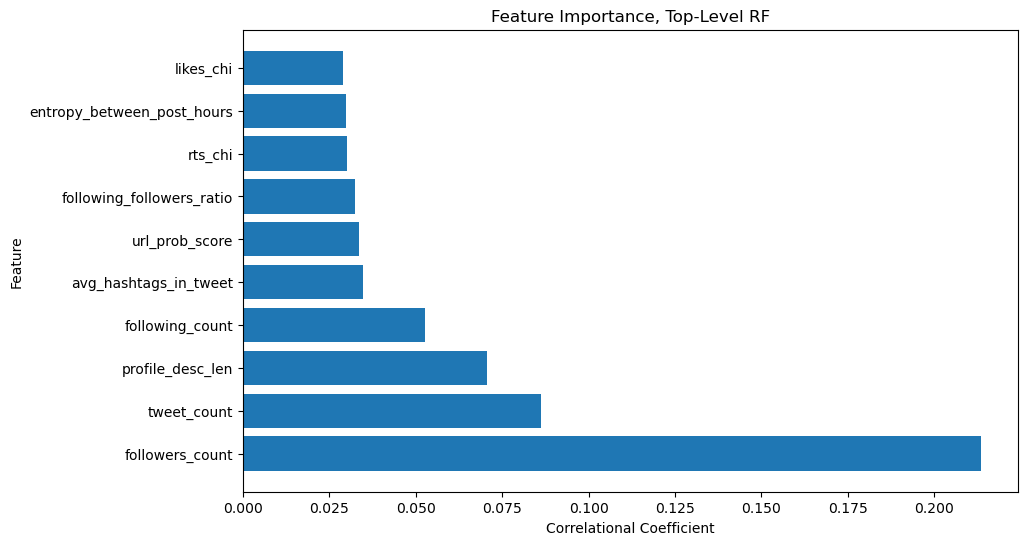

In [5]:
# A lot of bit of parameter tuning. Be aware that running this will take time.
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score, average_precision_score
# remove columns we no longer need or will not analyze here in whole
drop_list = [
             'id',
             'protected',
             'verified',
             'pinned_tweet_id',
             'sampled_tweet_count',
             'tweet_hashtags_top_x',
             'sampled_tweed_count',
             'name',
             'username',
             'location',
             'withheld',
             'url',
             'profile_image_url',
             'created_at',
             'entities',
             'tweet_urls_top_x',
             'description',
             'url.urls',                                         
             'description.urls',                                 
             'description.mentions',                             
             'description.hashtags',                             
             'description.cashtags', 
             'posts',

             'tweet_has_hashtag_weekday_entropy', 
             'tweet_has_hashtag_hour_entropy', 
             'tweet_has_url_weekday_entropy', 
             'tweet_has_url_hour_entropy'
            ]

pd.set_option('mode.use_inf_as_na', True)

# Drop columns that we aren't going to analyze
for column in drop_list:
    if column in compiled_df.columns:
        del compiled_df[column]

print(compiled_df.dtypes)
non_numeric_columns = []
for column in compiled_df.columns:
    if compiled_df[column].dtype == 'object' and column != 'label':  # Check for object type, avoid label
        try:
            # Try converting to numeric to detect non-numeric strings
            pd.to_numeric(compiled_df[column], errors='raise')
        except Exception:
            non_numeric_columns.append(column)

# Drop non-numeric columns
compiled_df.drop(columns=non_numeric_columns, inplace=True)

# Log dropped columns
if non_numeric_columns:
    print("The following columns were dropped because they contain non-numeric data:")
    print(non_numeric_columns)



if top_do_normalize:
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    normalize_floats = True
    float_columns = []  # List of floating-point columns to normalize

    # Identify float columns
    for column in compiled_df:
        if normalize_floats and compiled_df[column].dtype == 'float64':
            float_columns.append(column)

    scaler = MinMaxScaler()  # Alternatively: StandardScaler()
    columns_with_issues = []
    all_nan_columns = []

    # Normalize columns and handle issues
    for column in float_columns:
        if compiled_df[column].isna().all():
            all_nan_columns.append(column)
            print(f"Column '{column}' is entirely NaN and will be skipped.")
            continue
        try:
            # Normalize column independently
            compiled_df[[column]] = scaler.fit_transform(compiled_df[[column]].fillna(0))
        except Exception as e:
            columns_with_issues.append(column)
            print(f"Error normalizing column '{column}': {e}")

    if all_nan_columns:
        print("The following columns were entirely NaN and skipped:")
        print(all_nan_columns)

    if columns_with_issues:
        print("The following columns had issues during normalization:")
        print(columns_with_issues)

from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score

y = compiled_df['label']
X = compiled_df.drop(['label'], axis=1)

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Check shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)







kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    'criterion': ['gini','entropy'],
    'max_depth': [40,35],
    'min_samples_split': [15,10],
    'min_samples_leaf': [2,3],
    'max_features': [None],
    'max_leaf_nodes': [None,5],
    'min_impurity_decrease': [0.0],
    'n_estimators': [600,500],
    'class_weight': [None, 'balanced']
}
# Number of parameter settings to sample
n_iter_search = 30
                  
# previous 2 :{'n_estimators': 600,'min_samples_split': 15,'min_samples_leaf': 2,'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 40,'criterion': 'gini'} {'n_estimators': 600, 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 20, 'criterion': 'gini'}
if not top_level_rf_best_params :
    rFClass = RandomForestClassifier(random_state=42)
    scoring = {
        'f1': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
        'accuracy': make_scorer(accuracy_score),
        'average_precision': make_scorer(average_precision_score, needs_proba=True)
    }
    random_search = RandomizedSearchCV(
        estimator=rFClass,
        param_distributions=param_dist,
        n_iter=n_iter_search, 
        scoring=scoring,
        refit='f1',  # refit model using the best f1-score
        cv=kf,
        n_jobs=-1,
        verbose=n_verbose
    )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    print("Best parameters found: ", random_search.best_params_)
    print("Best F1 score: ", random_search.best_score_)
else:
    best_model = rFClass = RandomForestClassifier(random_state=42,  **top_level_rf_best_params )
    best_model.fit(X_train, y_train)


#Random Forest Classifier
y_pred_rf = best_model.predict(X_test)  # for predicted class labels
y_prob_rf = best_model.predict_proba(X_test)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

s_acc = accuracy_score(y_test, y_pred_rf)
s_f1 = f1_score(y_test, y_pred_rf, average='weighted')
s_roc = roc_auc_score(y_test, y_prob_rf[:, 1])
print("Accuracy:", s_acc)
print("F1 Score:", s_f1)
print("ROC AUC Score:", s_roc)

scores.update({'rf': (s_acc,s_f1,s_roc)})

import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model and X are defined elsewhere in your script
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
# Adjust layout to avoid cutting off labels
plt.tight_layout()
# Adjust layout or margins
#plt.subplots_adjust(left=0.3)  # Adjust left margin to avoid cutoff

top_n = 10
plt.figure(figsize=(10, 6))
plt.title("Feature Importance, Top-Level RF")
plt.barh(range(min(X.shape[1], top_n)), importances[indices][0:top_n], align="center")
plt.yticks(range(min(X.shape[1], top_n)), X.columns[indices[0:top_n]], rotation=0)
plt.xlabel('Correlational Coefficient')
plt.ylabel('Feature')
plt.savefig("feature_importances.png", transparent=True, dpi=300, bbox_inches = "tight")
plt.show()


## AHH, you're done. You should probably test the model against another set of samples now. 